# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

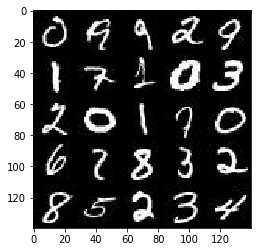

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

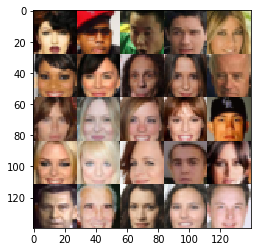

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):

    input_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    lr = tf.placeholder(tf.float32, name="learning_rate")

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):

    alpha = 0.2
    keep_prob = 0.8
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)

        # Flat
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):

    alpha = 0.2
    keep_prob = 0.8
    with tf.variable_scope("generator", reuse=not is_train):

        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):

    generator_model = generator(input_z, out_channel_dim, is_train=True)
    discriminator_model_real, discriminator_logits_real = discriminator(input_real, reuse=False)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True)

    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real,
                                                labels=tf.ones_like(discriminator_model_real)))
    discriminator_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, 
                                                labels=tf.zeros_like(discriminator_model_fake)))

    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, 
                                                labels=tf.ones_like(discriminator_model_fake)))

    discriminator_loss = discriminator_loss_real + discriminator_loss_fake

    return discriminator_loss, generator_loss
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):

    trainable_vars = tf.trainable_variables()
    discriminator_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in trainable_vars if var.name.startswith('generator')]

    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = discriminator_vars)

    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = generator_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
print("Ok")

Ok


### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)   
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print("Start ")
        show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)

        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})


                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),     
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
            
        
        show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)


            
print("Train function created")

Train function created


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Start 


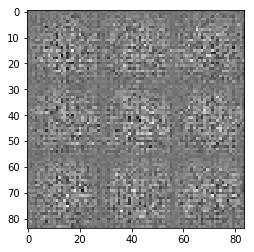

Epoch 1/2... Discriminator Loss: 2.9915... Generator Loss: 0.3238
Epoch 1/2... Discriminator Loss: 1.8456... Generator Loss: 0.5794
Epoch 1/2... Discriminator Loss: 3.0032... Generator Loss: 0.5231
Epoch 1/2... Discriminator Loss: 2.2789... Generator Loss: 0.2229
Epoch 1/2... Discriminator Loss: 2.3607... Generator Loss: 0.5418
Epoch 1/2... Discriminator Loss: 1.7718... Generator Loss: 0.6666
Epoch 1/2... Discriminator Loss: 1.5305... Generator Loss: 0.7669
Epoch 1/2... Discriminator Loss: 2.0694... Generator Loss: 0.7512
Epoch 1/2... Discriminator Loss: 1.5909... Generator Loss: 0.7491
Epoch 1/2... Discriminator Loss: 1.6088... Generator Loss: 0.8735


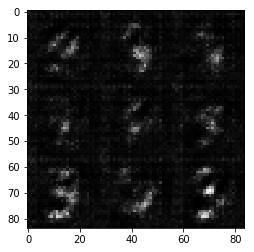

Epoch 1/2... Discriminator Loss: 1.4352... Generator Loss: 0.6646
Epoch 1/2... Discriminator Loss: 1.5939... Generator Loss: 0.8637
Epoch 1/2... Discriminator Loss: 1.5375... Generator Loss: 0.5008
Epoch 1/2... Discriminator Loss: 1.5465... Generator Loss: 0.5984
Epoch 1/2... Discriminator Loss: 1.5209... Generator Loss: 0.4684
Epoch 1/2... Discriminator Loss: 1.5181... Generator Loss: 0.8999
Epoch 1/2... Discriminator Loss: 1.5324... Generator Loss: 0.8674
Epoch 1/2... Discriminator Loss: 1.5456... Generator Loss: 0.5157
Epoch 1/2... Discriminator Loss: 1.4894... Generator Loss: 0.5264
Epoch 1/2... Discriminator Loss: 1.4025... Generator Loss: 0.7638


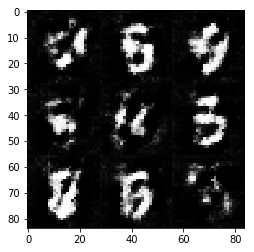

Epoch 1/2... Discriminator Loss: 1.4009... Generator Loss: 0.8672
Epoch 1/2... Discriminator Loss: 1.5164... Generator Loss: 1.1447
Epoch 1/2... Discriminator Loss: 1.4021... Generator Loss: 0.5079
Epoch 1/2... Discriminator Loss: 1.4615... Generator Loss: 1.0491
Epoch 1/2... Discriminator Loss: 1.4112... Generator Loss: 0.8255
Epoch 1/2... Discriminator Loss: 1.4485... Generator Loss: 0.5324
Epoch 1/2... Discriminator Loss: 1.4240... Generator Loss: 0.5695
Epoch 1/2... Discriminator Loss: 1.3725... Generator Loss: 0.6220
Epoch 1/2... Discriminator Loss: 1.4126... Generator Loss: 0.6310
Epoch 1/2... Discriminator Loss: 1.5205... Generator Loss: 0.5085


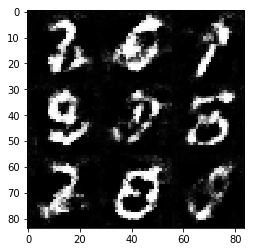

Epoch 1/2... Discriminator Loss: 1.3642... Generator Loss: 0.8307
Epoch 1/2... Discriminator Loss: 1.5335... Generator Loss: 1.1612
Epoch 1/2... Discriminator Loss: 1.4589... Generator Loss: 0.9460
Epoch 1/2... Discriminator Loss: 1.4257... Generator Loss: 0.6515
Epoch 1/2... Discriminator Loss: 1.3081... Generator Loss: 0.7505
Epoch 1/2... Discriminator Loss: 1.3733... Generator Loss: 0.6804
Epoch 1/2... Discriminator Loss: 1.5121... Generator Loss: 0.8674
Epoch 1/2... Discriminator Loss: 1.5872... Generator Loss: 1.1931
Epoch 1/2... Discriminator Loss: 1.4677... Generator Loss: 0.7879
Epoch 1/2... Discriminator Loss: 1.4614... Generator Loss: 1.0539


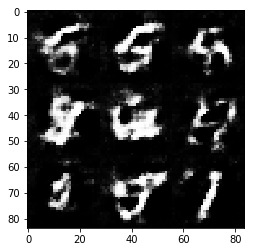

Epoch 1/2... Discriminator Loss: 1.5170... Generator Loss: 1.2220
Epoch 1/2... Discriminator Loss: 1.4637... Generator Loss: 0.5630
Epoch 1/2... Discriminator Loss: 1.4376... Generator Loss: 0.6991
Epoch 1/2... Discriminator Loss: 1.4094... Generator Loss: 0.7158
Epoch 1/2... Discriminator Loss: 1.3725... Generator Loss: 0.7272
Epoch 1/2... Discriminator Loss: 1.2906... Generator Loss: 0.7550
Epoch 2/2... Discriminator Loss: 1.4184... Generator Loss: 0.8604
Epoch 2/2... Discriminator Loss: 1.3419... Generator Loss: 0.9582
Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 0.7754
Epoch 2/2... Discriminator Loss: 1.4005... Generator Loss: 0.8910
Epoch 2/2... Discriminator Loss: 1.4124... Generator Loss: 0.6971
Epoch 2/2... Discriminator Loss: 1.4362... Generator Loss: 0.7853
Epoch 2/2... Discriminator Loss: 1.3514... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 1.3513... Generator Loss: 0.6348
Epoch 2/2... Discriminator Loss: 1.4437... Generator Loss: 0.6445
Epoch 2/2.

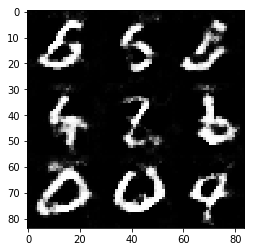

Epoch 2/2... Discriminator Loss: 1.3465... Generator Loss: 0.7276
Epoch 2/2... Discriminator Loss: 1.3662... Generator Loss: 0.6038
Epoch 2/2... Discriminator Loss: 1.4398... Generator Loss: 0.7081
Epoch 2/2... Discriminator Loss: 1.4049... Generator Loss: 0.8034
Epoch 2/2... Discriminator Loss: 1.3741... Generator Loss: 0.5958
Epoch 2/2... Discriminator Loss: 1.3755... Generator Loss: 0.6305
Epoch 2/2... Discriminator Loss: 1.4379... Generator Loss: 0.4945
Epoch 2/2... Discriminator Loss: 1.3854... Generator Loss: 0.7575
Epoch 2/2... Discriminator Loss: 1.4384... Generator Loss: 0.6590
Epoch 2/2... Discriminator Loss: 1.3885... Generator Loss: 0.7013


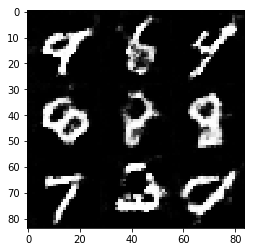

Epoch 2/2... Discriminator Loss: 1.4327... Generator Loss: 0.6005
Epoch 2/2... Discriminator Loss: 1.5544... Generator Loss: 0.4966
Epoch 2/2... Discriminator Loss: 1.3427... Generator Loss: 0.6671
Epoch 2/2... Discriminator Loss: 1.4170... Generator Loss: 0.7952
Epoch 2/2... Discriminator Loss: 1.3760... Generator Loss: 0.8060
Epoch 2/2... Discriminator Loss: 1.4319... Generator Loss: 0.6008
Epoch 2/2... Discriminator Loss: 1.4538... Generator Loss: 0.4604
Epoch 2/2... Discriminator Loss: 1.4227... Generator Loss: 0.8222
Epoch 2/2... Discriminator Loss: 1.5135... Generator Loss: 1.0668
Epoch 2/2... Discriminator Loss: 1.4131... Generator Loss: 0.7329


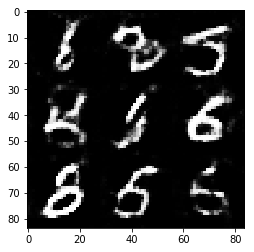

Epoch 2/2... Discriminator Loss: 1.3473... Generator Loss: 0.9008
Epoch 2/2... Discriminator Loss: 1.4517... Generator Loss: 1.0422
Epoch 2/2... Discriminator Loss: 1.3452... Generator Loss: 0.9474
Epoch 2/2... Discriminator Loss: 1.4516... Generator Loss: 0.7189
Epoch 2/2... Discriminator Loss: 1.4457... Generator Loss: 1.0101
Epoch 2/2... Discriminator Loss: 1.3867... Generator Loss: 0.9115
Epoch 2/2... Discriminator Loss: 1.3994... Generator Loss: 0.7926
Epoch 2/2... Discriminator Loss: 1.3901... Generator Loss: 0.7740
Epoch 2/2... Discriminator Loss: 1.4441... Generator Loss: 0.8228
Epoch 2/2... Discriminator Loss: 1.4153... Generator Loss: 0.8258


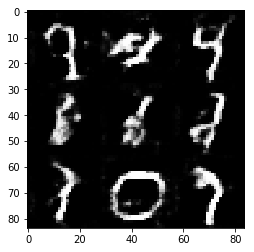

Epoch 2/2... Discriminator Loss: 1.3701... Generator Loss: 0.7809
Epoch 2/2... Discriminator Loss: 1.4088... Generator Loss: 0.6508
Epoch 2/2... Discriminator Loss: 1.3565... Generator Loss: 0.7734
Epoch 2/2... Discriminator Loss: 1.3995... Generator Loss: 0.8900
Epoch 2/2... Discriminator Loss: 1.3811... Generator Loss: 0.9238
Epoch 2/2... Discriminator Loss: 1.3512... Generator Loss: 0.7083


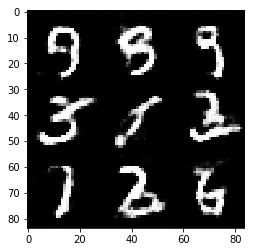

End MNIST


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
    
print("End MNIST")

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Start 


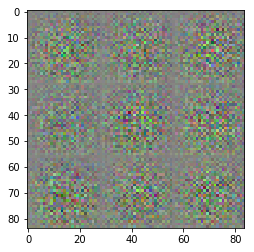

Epoch 1/1... Discriminator Loss: 3.0549... Generator Loss: 0.2340
Epoch 1/1... Discriminator Loss: 2.1562... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 2.5930... Generator Loss: 0.5011
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 2.5682... Generator Loss: 0.4105
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 1.1051
Epoch 1/1... Discriminator Loss: 2.1141... Generator Loss: 0.2739
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 1.5130
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 1.5694


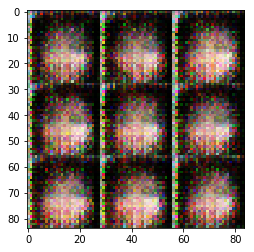

Epoch 1/1... Discriminator Loss: 0.6874... Generator Loss: 1.8810
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.6525... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.6497... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 1.6889... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.6057... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.7970... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.7260... Generator Loss: 0.4390
Epoch 1/1... Discriminator Loss: 1.6652... Generator Loss: 0.5819


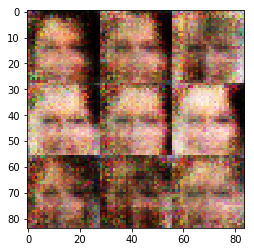

Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 0.4887
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 1.1101
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.6741... Generator Loss: 0.9588
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.9045
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.9884
Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.6489


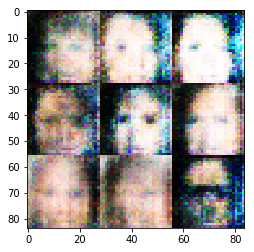

Epoch 1/1... Discriminator Loss: 1.8299... Generator Loss: 0.4447
Epoch 1/1... Discriminator Loss: 1.7101... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.8843... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.4736
Epoch 1/1... Discriminator Loss: 1.7250... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.8385... Generator Loss: 0.6025


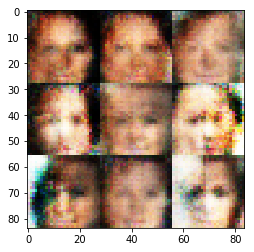

Epoch 1/1... Discriminator Loss: 1.5827... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.6112... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.6289... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.5371
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 1.6621... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 1.5939... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.5621... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.6386... Generator Loss: 0.5805


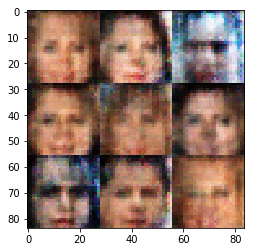

Epoch 1/1... Discriminator Loss: 1.7983... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 0.5360
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.6388... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.6193... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.6386... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.6959... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 0.6962


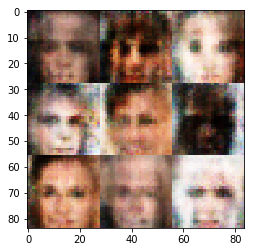

Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.6729... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.6565... Generator Loss: 0.5241
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.5433... Generator Loss: 0.6601


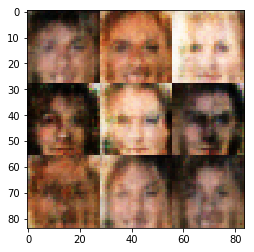

Epoch 1/1... Discriminator Loss: 1.6199... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.5880


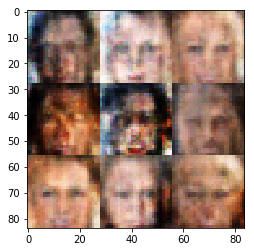

Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.5513... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.5608... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.6132... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.5626... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.6501


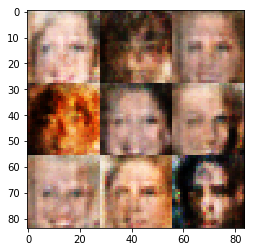

Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.5834... Generator Loss: 0.6055


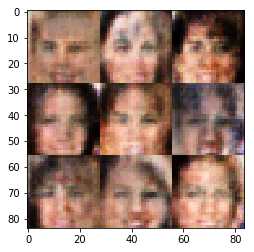

Epoch 1/1... Discriminator Loss: 1.4883... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.5933... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.5603... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 0.6567


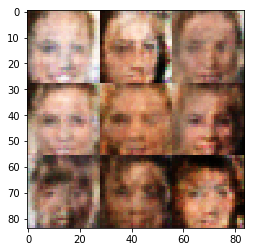

Epoch 1/1... Discriminator Loss: 1.6226... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.5413... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.6218


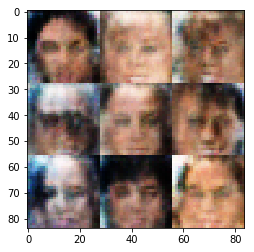

Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7047


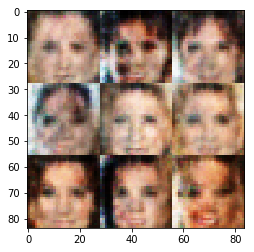

Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.5150... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.5173... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.5616... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.5672... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.6110


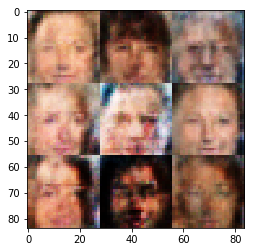

Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.5493... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6422


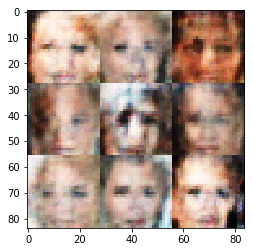

Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6323


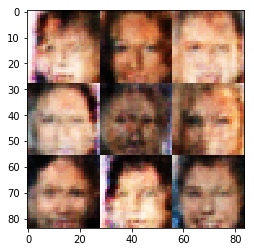

Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.6664


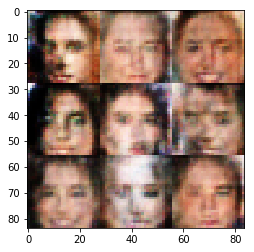

Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.6355


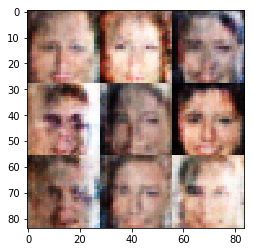

Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.6740


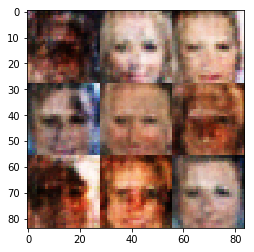

Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.6882


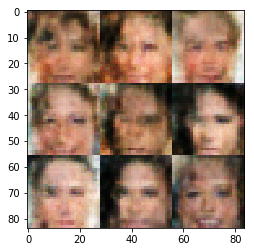

Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.6391


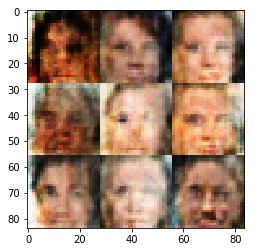

Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.5933
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.6707


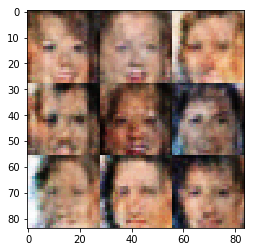

Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6029


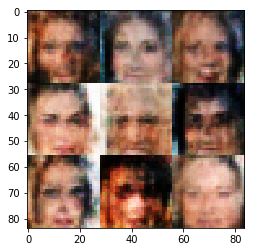

Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.6675


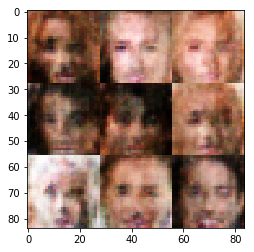

Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.6997


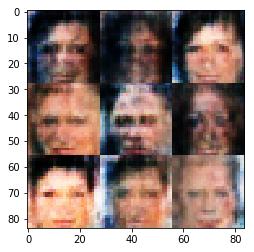

Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.6632


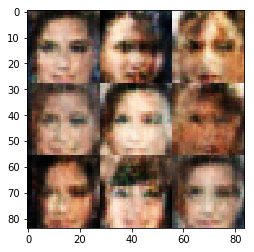

Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6173


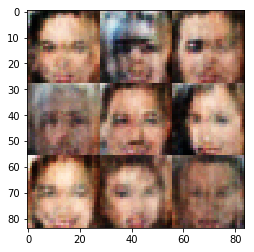

Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.7104


KeyboardInterrupt: 

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.